# Vision Transformers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
from torch import nn, einsum

from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [2]:
# The size of our mini batches
batch_size = 64
# How many itterations of our dataset
num_epochs = 50
# Optimizer learning rate
learning_rate = 1e-4
# Where to load/save the dataset from 
data_set_root = "../../datasets"

patch_size = 8

In [3]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

<h3> Create a transform for the input data </h3>
As we have seen, we often wish to perform some operations on data before we pass it through our model. Such operations could be, cropping or resizing images, affine transforms and data normalizations. Pytorch's torchvision module has a large number of such "transforms" which can be strung together sequentially using the "Compose" function. <br>

Pytorch's inbuilt datasets take a transform as an input and will apply this transform to the data before passing it to you! This makes preprocessing data really easy! We will see more about data preprocessing in a later lab!

[torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html#)

In [4]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE: some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

# Note: ToTensor() will scale unit8 and similar type data to a float and re-scale to 0-1
# Note: We are normalizing with the dataset mean and std 

<h3> Create the training, testing and validation data</h3>
When training many machine learning systems it is best practice to have our TOTAL dataset split into three segments, the training set, testing set and validation set. Up until now we have only had a train/test set split and have used the test set to gauge the performance during training. Though for the most "unbiased" results we should really not use our test set until training is done! So if we want to evaluate our model on an "unseen" part of the dataset we need another split - the validation set. <br><br>
<b>Training set</b>   - the data we train our model on<br>
<b>Validation set</b> - the data we use to gauge model performance during training<br>
<b>Testing set</b>   - the data we use to "rate" our trained model<br>

In [5]:
train_data = datasets.CIFAR10(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(data_set_root, train=False, download=True, transform=transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))

# IMPORTANT TO KNOW!!!!!!!!!
# Here we pass the random_split function a manual seed, this is very important as if we did not do this then 
# everytime we randomly split our training and validation set we would get different splits!!!
# For example if we saved our model and reloaded it in the future to train some more, the dataset that we now use to
# train with will undoubtably contain datapoints that WERE in the validation set initially!!
# Our model would therefore be trained with both validation and training data -- very bad!!!
# Setting the manual seed to the same value everytime prevents this!

Files already downloaded and verified
Files already downloaded and verified


<h3> Check the lengths of all the datasets</h3>

In [6]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


<h3> Create the dataloader</h3>

In [7]:
# Create the training, Validation and Evaluation/Test Datasets
# It is best practice to separate your data into these three Datasets
# Though depending on your task you may only need Training + Evaluation/Test or maybe only a Training set
# (It also depends on how much data you have)
# https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataloader
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

<h2> Create the Vision Transformer network</h2>

In [8]:
def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

# Transformer block with self-attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4):
        super(TransformerBlock, self).__init__()
        
        self.norm1 = nn.LayerNorm(hidden_size)
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, batch_first=True)
        
        self.norm2 = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.LayerNorm(hidden_size * 4),
                                 nn.ELU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x):
        norm_x = self.norm1(x)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x
        
        norm_x = self.norm2(x)
        x = self.mlp(norm_x) + x
        return x
    

class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size, num_layers, num_heads=8):
        # Call the __init__ function of the parent nn.module class
        super(ViT, self).__init__()
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, 10)
        
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))
                
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.02))

    def forward(self, image):
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        patch_emb = patch_emb + self.pos_embedding
        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        for block in self.blocks:
            embs = block(embs)
        
        output = F.elu(embs)
        return self.fc_out(output[:, 0])

<h3> Create our model and view the ouput! </h3>

In [9]:
# Create a dataloader itterable object
dataiter = next(iter(test_loader))
# Sample from the itterable object
test_images, test_labels = dataiter

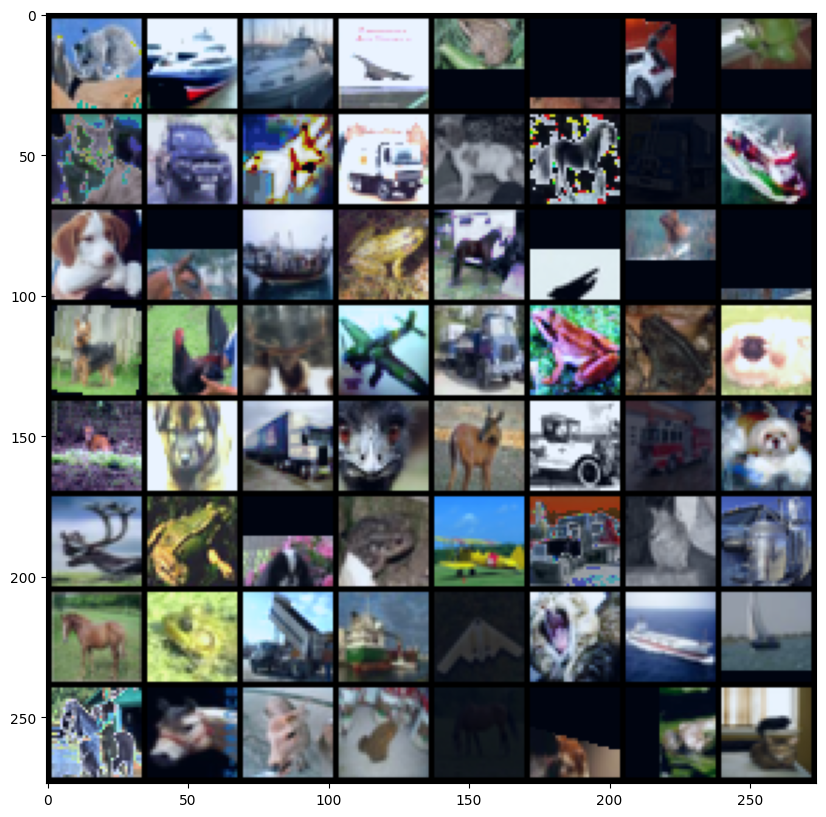

In [10]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [11]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images (1 channel for MNIST)
model = ViT(image_size=test_images.shape[2], 
            channels_in=test_images.shape[1], 
            patch_size=patch_size, 
            hidden_size=256,
            num_layers=6).to(device)

# View the network
# Note that the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

ViT(
  (fc_in): Linear(in_features=192, out_features=256, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Dropout(p=0.5, inplace=False)
        (4): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
)


In [12]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 4807178 (Approximately 4 Million) Parameters!


In [13]:
# Pass image through network
out = model(test_images.to(device))
# Check output
out.shape

torch.Size([64, 10])

<h3> Set up the optimizer </h3>

In [14]:
# Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [15]:
# Define a Cross Entropy Loss
loss_fun = nn.CrossEntropyLoss()

# Define the training process

In [16]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):
    
    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx = model(x.to(device))
        
        # Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))

        # Zero Gradents
        optimizer.zero_grad()
        # Backpropagate Gradents
        loss.backward()
        # Do a single optimization step
        optimizer.step()
        
        # Log the loss for plotting
        loss_logger.append(loss.item())
        
    # Return the avaerage loss and acc from the epoch as well as the logger array       
    return model, optimizer, loss_logger

# Define the testing process

In [17]:
# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):
    
    # Initialise counter
    epoch_acc = 0
    
    # Set network in evaluation mode
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    # and use current stored values (More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            fx = model(x.to(device))
            
            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()
            
    # Return the accuracy from the epoch     
    return epoch_acc / len(loader.dataset)

# The training process

In [18]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [ ]:
valid_acc = 0
train_acc = 0

# This cell implements our training loop
pbar = trange(0, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))
    
    # Call the training function and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model=model, 
                                                   optimizer=optimizer, 
                                                   loader=train_loader, 
                                                   device=device, 
                                                   loss_fun=loss_fun, 
                                                   loss_logger=training_loss_logger)
    
    # Call the evaluate function and pass the dataloader for both validation and training
    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)
    
    # Log the train and validation accuracies
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)
    
print("Training Complete")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/704 [00:00<?, ?it/s]

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("LeNet Training Loss")

In [ ]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("LeNet")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [ ]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

In [ ]:
# 65.21%
# 64.01%

In [ ]:
# Lets visualise the prediction for a few test images!

with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))